# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_extraction.text import TfidfVectorizer

import operator
from sklearn import set_config
import seaborn as sns
import re
import time
import warnings
warnings.filterwarnings('ignore')

In [15]:
df = pd.read_csv('/content/sample_data/bank-additional-full.csv', sep = ';')


In [16]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [17]:
df.drop(columns=['duration'],inplace = True)

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



Value counts for each feature 1.Analyse how the data is distributed 2.How many unknowns

In [18]:
for var in df:
    print('*********************************************************')
    print('---------------------------')
    print(var)
    print('---------------------------')
    print(df[var].value_counts())

*********************************************************
---------------------------
age
---------------------------
31    1947
32    1846
33    1833
36    1780
35    1759
      ... 
89       2
91       2
94       1
87       1
95       1
Name: age, Length: 78, dtype: int64
*********************************************************
---------------------------
job
---------------------------
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
*********************************************************
---------------------------
marital
---------------------------
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
*********************************************************
---------------------------

Adding age_range feature for initial analysis

In [19]:
df['age'].value_counts().tail(20)

bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 100]
groups = ['Below 20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70', '70-75', '75+']

df['age_range'] = pd.cut(df['age'],bins,labels = groups)

Plot all the features to the target feature

<Figure size 720x288 with 0 Axes>

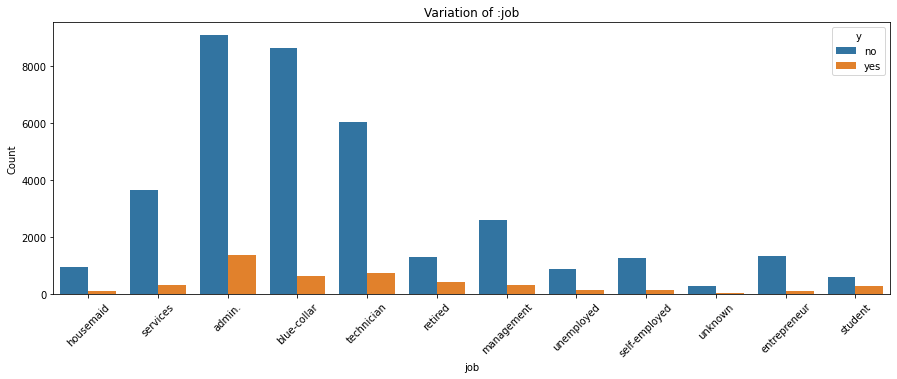

<Figure size 720x288 with 0 Axes>

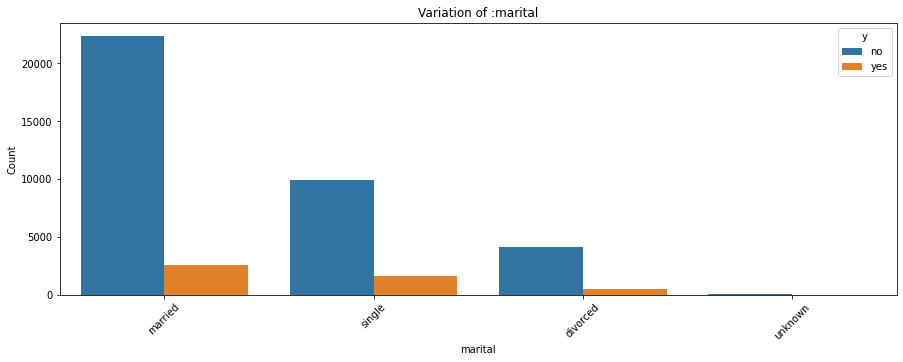

<Figure size 720x288 with 0 Axes>

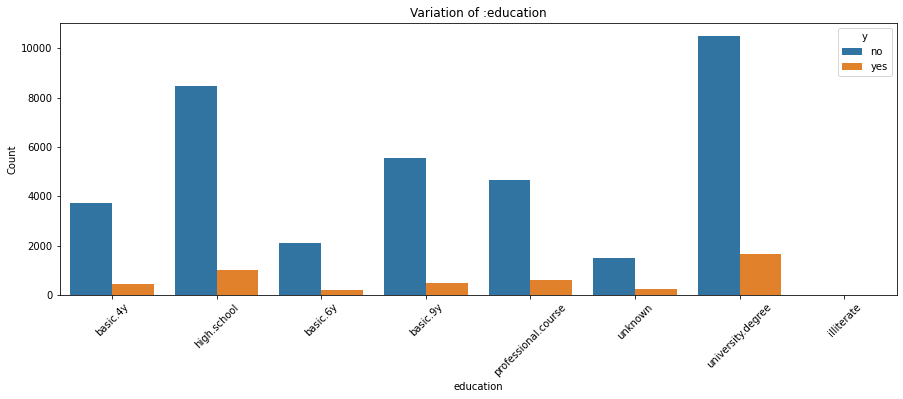

<Figure size 720x288 with 0 Axes>

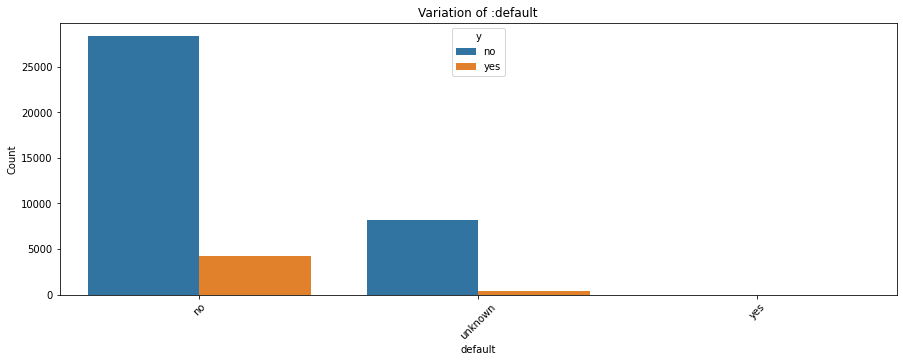

<Figure size 720x288 with 0 Axes>

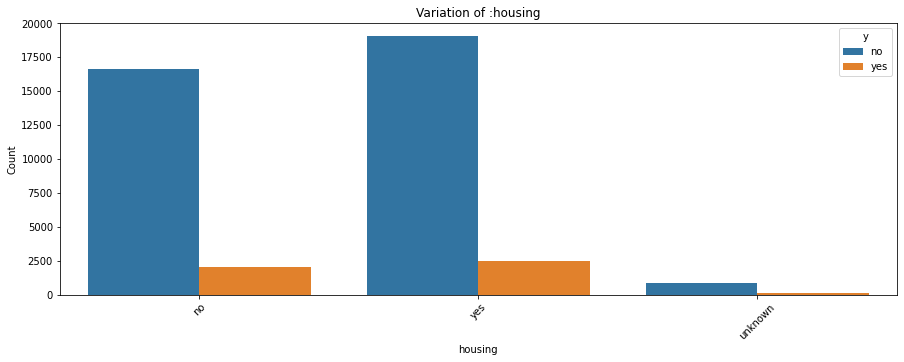

<Figure size 720x288 with 0 Axes>

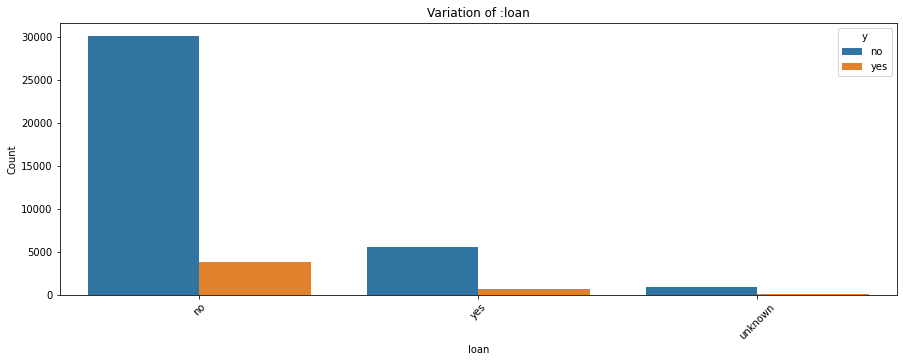

<Figure size 720x288 with 0 Axes>

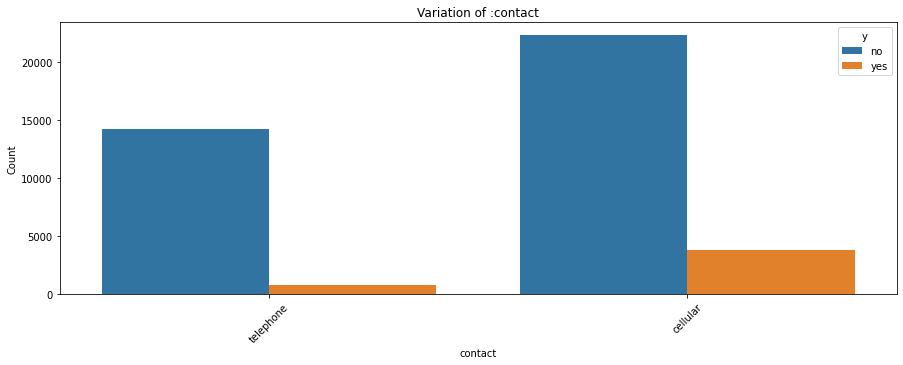

<Figure size 720x288 with 0 Axes>

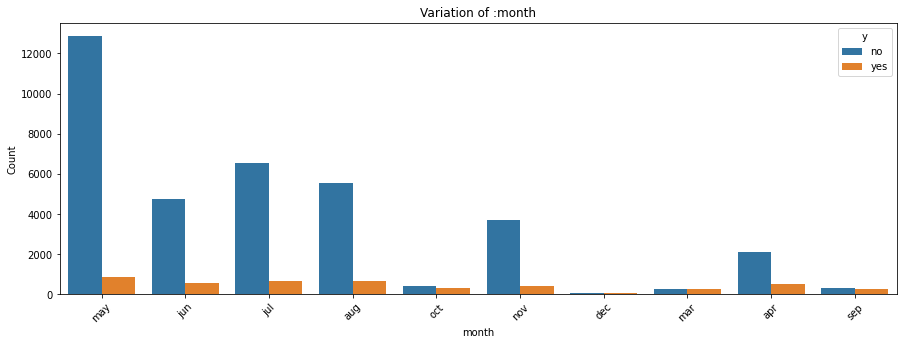

<Figure size 720x288 with 0 Axes>

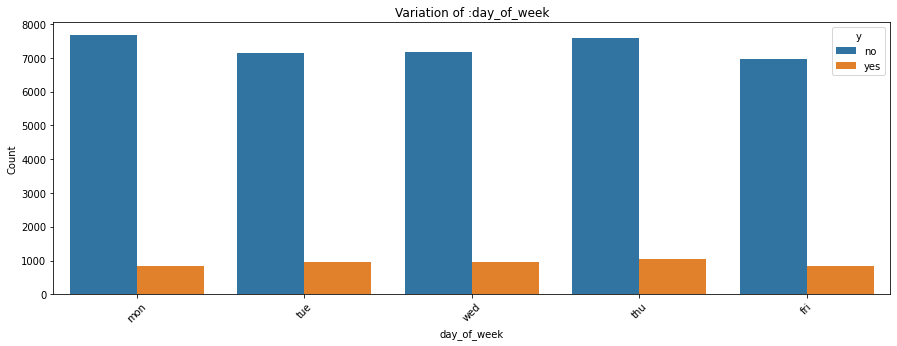

<Figure size 720x288 with 0 Axes>

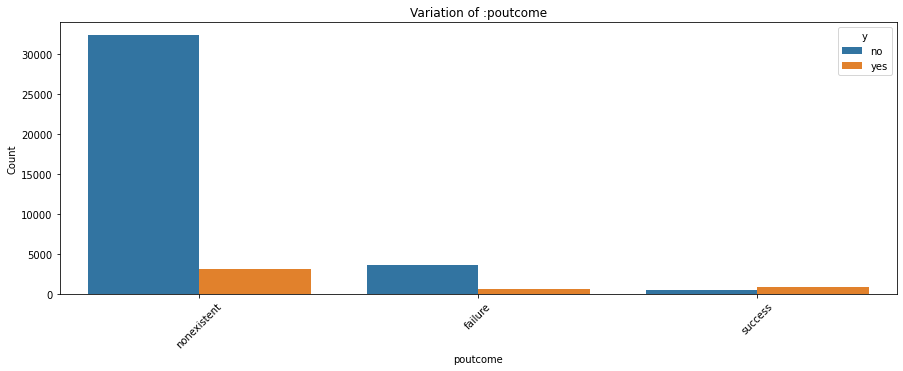

<Figure size 720x288 with 0 Axes>

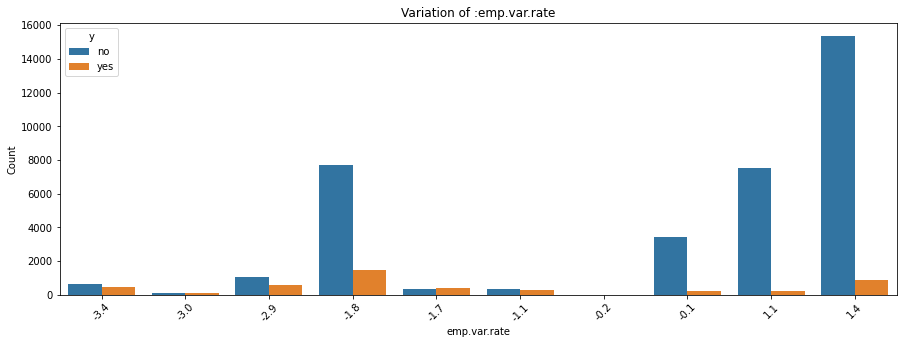

<Figure size 720x288 with 0 Axes>

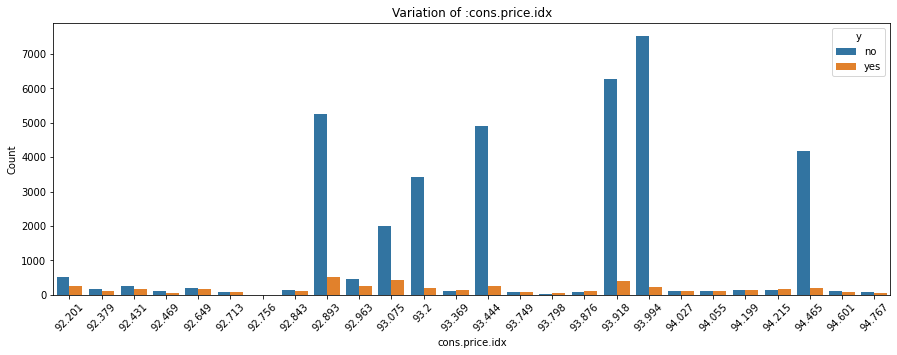

<Figure size 720x288 with 0 Axes>

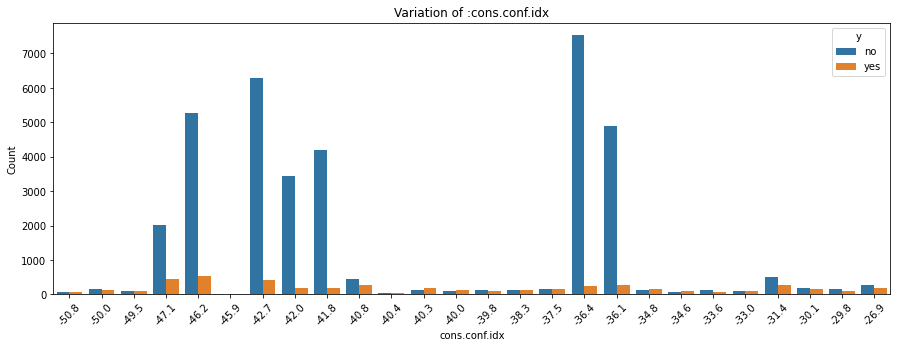

<Figure size 720x288 with 0 Axes>

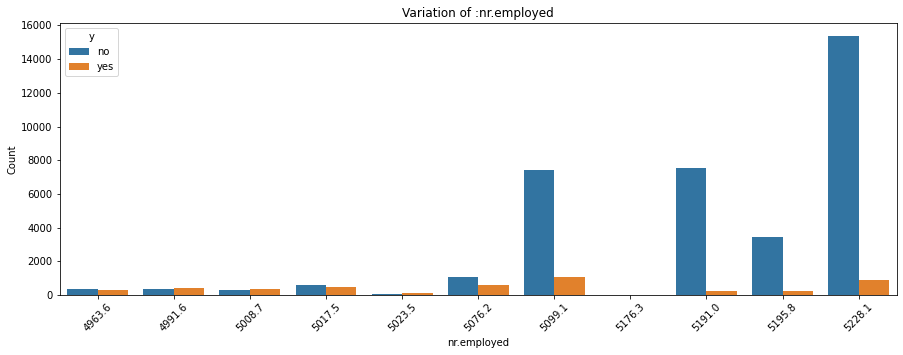

<Figure size 720x288 with 0 Axes>

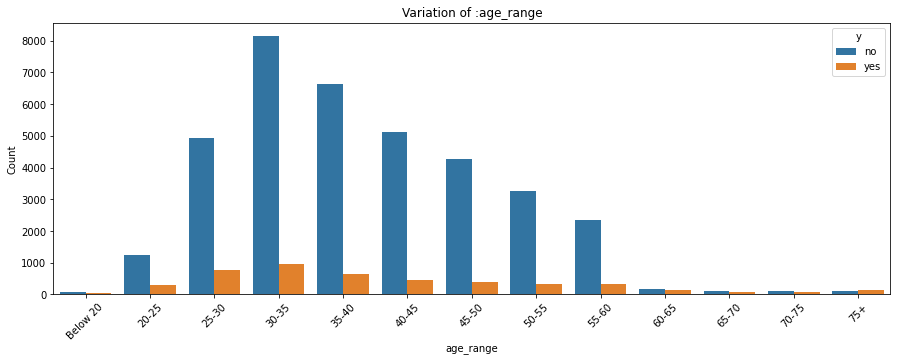

<Figure size 720x288 with 0 Axes>

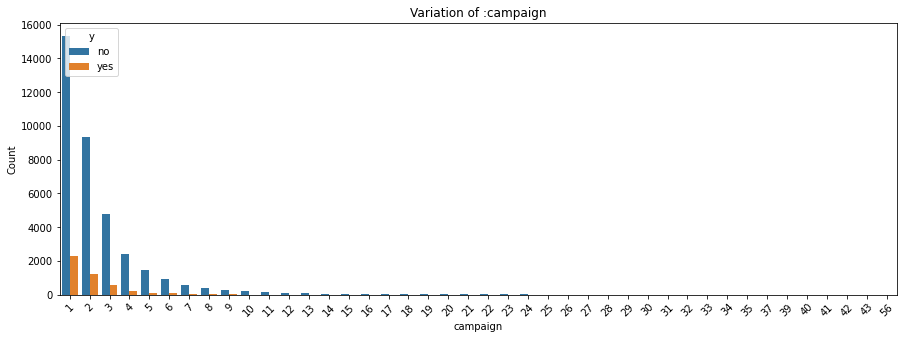

<Figure size 720x288 with 0 Axes>

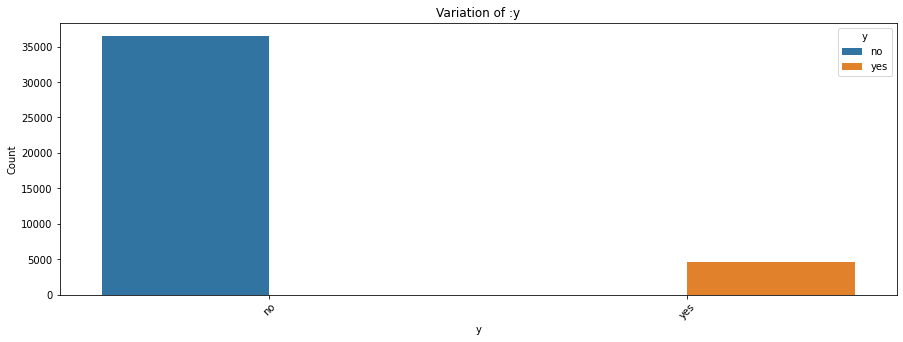

<Figure size 720x288 with 0 Axes>

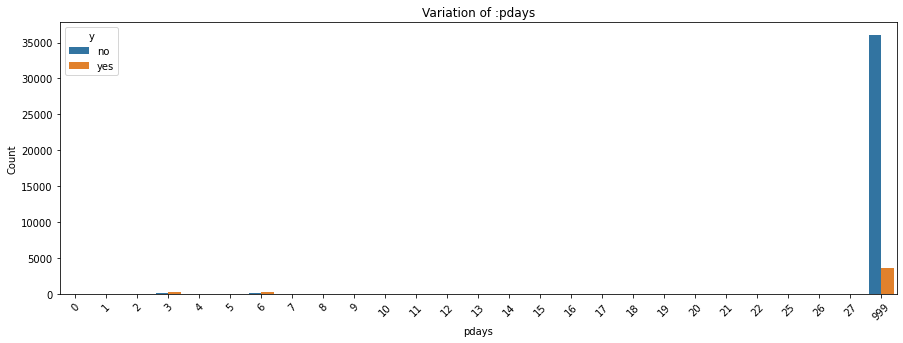

In [20]:
def analyze_cont_vars(df,var):
    
    new_df = df.copy()
    fig, ax = plt.subplots(figsize=(15, 5))
    ax = sns.countplot(x=var, hue="y", data=new_df, ax = ax)
    plt.xlabel(var)
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.title('Variation of :'+ var)
    plt.show()
    
columns_to_plot = df[['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome','emp.var.rate','cons.price.idx','cons.conf.idx','nr.employed','age_range','campaign','y','pdays']]

for var in columns_to_plot:
    plt.figure(figsize=(10,4))
    analyze_cont_vars(columns_to_plot,var)

#### Comparing euribor3m with target values

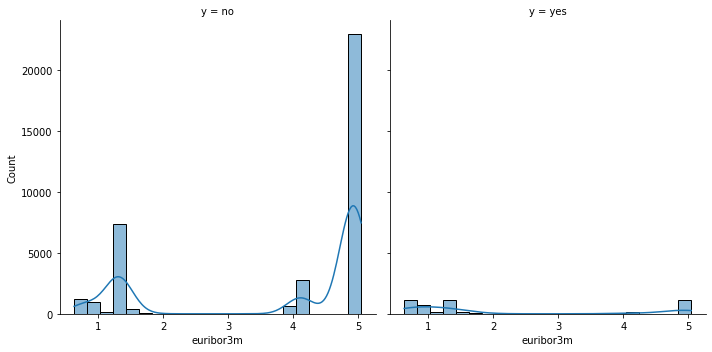

In [21]:
sns.displot(data=df, x="euribor3m", col="y", kde=True)

In [22]:
data = df
df['y'] = df.y.map(dict(yes=1, no=0))
df['default'] = df.default.map(dict(yes=1, no=0, unknown=0))
df['housing'] = df.housing.map(dict(yes=1, no=0, unknown=0))
df['loan'] = df.loan.map(dict(yes=1, no=0, unknown=0))
df['contact'] = df.contact.map(dict(telephone=1, cellular=0))


#### The unknown in job is mapped as unemployed, in marital it is mapped to single, and in education it is mapped to illiterate

In [23]:
df['job'] = df.job.map(dict(unknown='unemployed'))
df['marital'] = df.marital.map(dict(unknown='single'))
df['education'] = df.education.map(dict(unknown='illiterate'))

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Have to find how the model improves when additional features are added. 

When adding euribor3m, other economic related fields and previous customer status the model should improve. Can the model improves the sales representive will have high chance to call right customer.

Below is the process to find the important feature and the features - age, loan,contact,day_of_week from the dataset appears to be least important.

To find the important feature from the given 19 features, the categorial data is mapped in 2 ways to extract the features

1. mapped to codes

2. hot coded


And then perfoming all the 3 methods to find the features which plays important role in target classification.

1. permutation_importance with simple LogisticRegression on the dataset
2. Comparing the correlation to the target y value
3. Using SequentialFeatureSelector for finding the first 10(with categorical codes) /15(Hot codeing) imporatant features.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41188 non-null  int64   
 1   job             330 non-null    object  
 2   marital         80 non-null     object  
 3   education       1731 non-null   object  
 4   default         41188 non-null  int64   
 5   housing         41188 non-null  int64   
 6   loan            41188 non-null  int64   
 7   contact         41188 non-null  int64   
 8   month           41188 non-null  object  
 9   day_of_week     41188 non-null  object  
 10  campaign        41188 non-null  int64   
 11  pdays           41188 non-null  int64   
 12  previous        41188 non-null  int64   
 13  poutcome        41188 non-null  object  
 14  emp.var.rate    41188 non-null  float64 
 15  cons.price.idx  41188 non-null  float64 
 16  cons.conf.idx   41188 non-null  float64 
 17  euribor3m   

Using permutation_importance to find the feature importance by dummy values to the categorial values

In [25]:
data_codes = df

data_codes.drop(columns=['emp.var.rate'],inplace = True)
data_codes['job'] = data_codes['job'].astype('category').cat.codes
data_codes['marital'] = data_codes['marital'].astype('category').cat.codes
data_codes['education'] = data_codes['education'].astype('category').cat.codes
data_codes['month'] = data_codes['month'].astype('category').cat.codes
data_codes['day_of_week'] = data_codes['day_of_week'].astype('category').cat.codes
data_codes['poutcome'] = data_codes['poutcome'].astype('category').cat.codes

y = data_codes['y']
X = data_codes.drop(columns=['y','age_range'])
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

log_model = LogisticRegression().fit(X_train, y_train)

r = permutation_importance(log_model, X_train, y_train, n_repeats = 10, random_state = 123)

pd.DataFrame({"Variable":X.columns, "Score":r.importances_mean}).sort_values(by = "Score", ascending = False)

,Variable,Score
11,pdays,0.013652
16,euribor3m,0.007724
17,nr.employed,0.002577
15,cons.conf.idx,0.001120
10,campaign,0.000624
8,month,0.000517
14,cons.price.idx,0.000451
9,day_of_week,0.000125
1,job,0.000000
6,loan,0.000000


Correlation between the features

nr.employed, pdays, euribor3m, emp.var.rate, previous, cons.price.idx, contact, poutcome

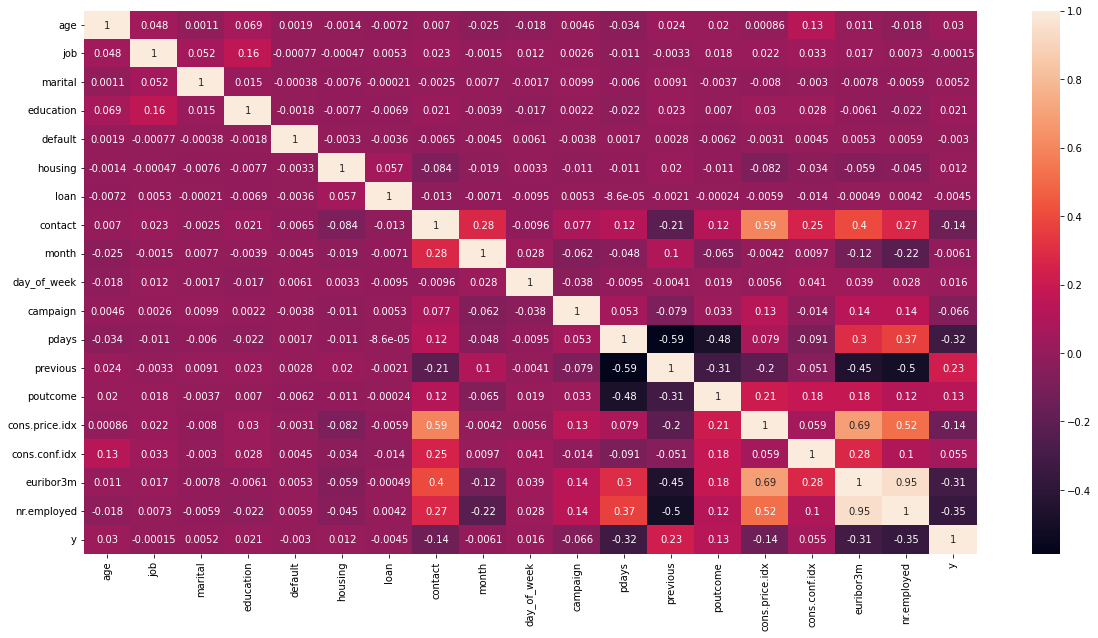

In [26]:
fig, ax = plt.subplots(figsize=(20,10))  
sns.heatmap(data_codes.corr(),annot=True,ax=ax)

Selecting the important features using SequentialFeatureSelector

In [27]:
sfs = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=10).fit(X_train, y_train)

In [28]:
feature_names = X_train.columns
feature_names[sfs.get_support()]

Index(['age', 'default', 'month', 'campaign', 'pdays', 'previous',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

#### Now are considering the features by hot codeing some categorical features (marital, job, education, month, day_of_week, poutcome)
1. permutation_importance with simple LogisticRegression on the dataset
2. Comparing the correlation to the target y value
3. Using SequentialFeatureSelector for finding the first 15 imporatant features.

#### 1. permutation_importance with simple LogisticRegression on the dataset

data_improv = df

cat_features = ['marital','job','education','month','day_of_week','poutcome']
for var in cat_features:
    tempdf = pd.get_dummies(data_improv[var],prefix=var)
    data_improv = pd.merge(left=data_improv,right=tempdf,left_index=True,right_index=True)

X = data_improv.copy()
X.drop(columns = ['marital','job','education','month','day_of_week','poutcome','age_range','y'],inplace=True)
y = data_improv['y']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

log_model = LogisticRegression().fit(X_train, y_train)

r = permutation_importance(log_model, X_train, y_train, n_repeats = 10, random_state = 123)

pd.DataFrame({"Variable":X.columns, "Score":r.importances_mean}).sort_values(by = "Score", ascending = False)

In [29]:
data_improv = df

cat_features = ['marital','job','education','month','day_of_week','poutcome']
for var in cat_features:
    tempdf = pd.get_dummies(data_improv[var],prefix=var)
    data_improv = pd.merge(left=data_improv,right=tempdf,left_index=True,right_index=True)

X = data_improv.copy()
X.drop(columns = ['marital','job','education','month','day_of_week','poutcome','age_range','y'],inplace=True)
y = data_improv['y']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

log_model = LogisticRegression().fit(X_train, y_train)

r = permutation_importance(log_model, X_train, y_train, n_repeats = 10, random_state = 123)

pd.DataFrame({"Variable":X.columns, "Score":r.importances_mean}).sort_values(by = "Score", ascending = False)

,Variable,Score
6,pdays,0.012795
10,euribor3m,0.007971
11,nr.employed,0.002088
9,cons.conf.idx,0.000763
5,campaign,0.000576
8,cons.price.idx,0.000506
29,day_of_week_1,0.000000
23,month_5,0.000000
25,month_7,0.000000
26,month_8,0.000000


#### 2. Comparing the correlation to the target y value

In [30]:
data_temp = pd.DataFrame(data_improv[data_improv.columns[1:]].corr()['y'][:]).abs().sort_values(by = 'y', ascending = False)
data_temp = data_temp.reset_index()
data_temp = data_temp.rename(columns={"index": "Variable"})
data_temp

,Variable,y
0,y,1.000000
1,nr.employed,0.354678
2,pdays,0.324914
3,poutcome_2,0.316269
4,euribor3m,0.307771
5,previous,0.230181
6,poutcome_1,0.193507
7,contact,0.144773
8,month_5,0.144014
9,month_8,0.137366


#### 3. Using SequentialFeatureSelector for finding the first 15 imporatant features.

In [31]:
sfs = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=15).fit(X_train, y_train)

In [32]:
feature_names = X_train.columns
data_sfs = pd.DataFrame(feature_names[sfs.get_support()])
data_sfs

,0
0,default
1,loan
2,campaign
3,pdays
4,euribor3m
5,marital_0
6,job_0
7,education_-1
8,education_0
9,month_3


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

The features marital, job, education are encoded with dummies


In [33]:
data_initial = df[['age','marital','job','education','default','housing','loan','y']]

cat_features = ['marital','job','education']
for var in cat_features:
    tempdf = pd.get_dummies(data_initial[var],prefix=var)
    data_initial = pd.merge(left=data_initial,right=tempdf,left_index=True,right_index=True)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [34]:
X = data_initial.copy()
X.drop(columns = ['marital','job','education','y'],inplace=True)
y = data_initial['y']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

#### Since the dataset is imbalanced, measuring accuracy will not help identifying the best model.
In the bank telemarketing we do not want to miss the positive prediction, recall would be the baseline performance metrics this will focus mainly on.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [35]:
log_model = LogisticRegression().fit(X_train, y_train)


In [36]:
preds = log_model.predict(X_test)

print("Accuracy: ",accuracy_score(y_test, preds))
print("Precision: ",precision_score(y_test, preds))
print("Recall: ",recall_score(y_test, preds))

Accuracy:  0.8875940762320952
Precision:  0.0
Recall:  0.0


### Problem 9: Score the Model

What is the accuracy of your model?

#### The accuracy of your model is 0.8875940762320952

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [37]:
pipelines = []

pipelines.append(('LogReg', LogisticRegression()))
pipelines.append(('KNN', KNeighborsClassifier()))
pipelines.append(('Decision', DecisionTreeClassifier()))
pipelines.append(('SVM', SVC()))

model_name = []
time_execution = []
test_accuracy = []
train_accuracy = []
test_score = []
train_score = []
test_recall = []

for pipe ,model in pipelines:
    model_name.append(pipe)
    start = time.time()
    mod = model.fit(X_train ,y_train)
    time_execution.append(time.time()- start)
    train_score.append(mod.score(X_train, y_train))
    test_score.append(mod.score(X_test, y_test))
    test_accuracy.append(accuracy_score(y_test, mod.predict(X_test)))
    train_accuracy.append(accuracy_score(y_train, mod.predict(X_train)))
    test_recall.append(recall_score(y_test, mod.predict(X_test)))
    
d = {'Model':model_name,'Train Time':time_execution,'Train Accuracy':train_accuracy,'Test Accuracy':test_accuracy,'Train Score':train_score,'Test Score':test_score,'Test Recall':test_recall}
performance_matrix = pd.DataFrame(d)

performance_matrix

,Model,Train Time,Train Accuracy,Test Accuracy,Train Score,Test Score,Test Recall
0,LogReg,0.480584,0.887239,0.887594,0.887239,0.887594,0.000000
1,KNN,0.063557,0.889147,0.886056,0.889147,0.886056,0.034557
2,Decision,0.023468,0.891748,0.885733,0.891748,0.885733,0.033117
3,SVM,10.808969,0.887239,0.887594,0.887239,0.887594,0.000000


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### All the categorical features are encoded with dummies

#### From the outcome of Understanding the Task section, 

The features - age, loan, contact, day_of_week are dropped and other categorial features are hot coded



In [38]:
data_improv = df

cat_features = ['marital','job','education','month','poutcome']
for var in cat_features:
    tempdf = pd.get_dummies(data_improv[var],prefix=var)
    data_improv = pd.merge(left=data_improv,right=tempdf,left_index=True,right_index=True)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41188 non-null  int64   
 1   job             41188 non-null  int8    
 2   marital         41188 non-null  int8    
 3   education       41188 non-null  int8    
 4   default         41188 non-null  int64   
 5   housing         41188 non-null  int64   
 6   loan            41188 non-null  int64   
 7   contact         41188 non-null  int64   
 8   month           41188 non-null  int8    
 9   day_of_week     41188 non-null  int8    
 10  campaign        41188 non-null  int64   
 11  pdays           41188 non-null  int64   
 12  previous        41188 non-null  int64   
 13  poutcome        41188 non-null  int8    
 14  cons.price.idx  41188 non-null  float64 
 15  cons.conf.idx   41188 non-null  float64 
 16  euribor3m       41188 non-null  float64 
 17  nr.employed 

In [40]:
X = data_improv.copy()
X.drop(columns = ['age','loan','contact','marital','job','education','month','day_of_week','poutcome','age_range','y'],inplace=True)
y = data_improv['y']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

#### Hyperparameter tuning and grid search. All of our models have additional hyperparameters to tune and explore. For example the number of neighbors in KNN or the maximum depth of a Decision Tree.

In [41]:
model_name = []
time_execution = []
test_accuracy = []
test_recall = []
test_precision = []
best_param = []

LogisticRegression

In [42]:
pipe = Pipeline([('model', LogisticRegression())])
params = [{'model__penalty': ['l1', 'l2'],
           'model__C': np.logspace(0, 4, 10)}]
start = time.time()
gs_knn = GridSearchCV(pipe,param_grid=params).fit(X_train, y_train)
y_predict = gs_knn.predict(X_test)

model_name.append('LogisticRegression()')
test_accuracy.append(accuracy_score(y_test,y_predict))
test_recall.append(recall_score(y_test,y_predict))
test_precision.append(precision_score(y_test,y_predict))
best_param.append(gs_knn.best_params_)
time_execution.append(time.time() - start)

KNeighborsClassifier

In [43]:
pipe = Pipeline([('model', KNeighborsClassifier())])
params = [{'model__n_neighbors': [3, 5, 7, 9],
         'model__weights': ['uniform', 'distance'],
         'model__leaf_size': [15, 20]}]
start = time.time()
gs_knn = GridSearchCV(pipe,param_grid=params).fit(X_train, y_train)
y_predict = gs_knn.predict(X_test)

model_name.append('KNeighborsClassifier()')
test_accuracy.append(accuracy_score(y_test,y_predict))
test_recall.append(recall_score(y_test,y_predict))
test_precision.append(precision_score(y_test,y_predict))
best_param.append(gs_knn.best_params_)
time_execution.append(time.time() - start)

In [44]:
confusion_matrix(y_test, y_predict)

array([[10680,   288],
       [ 1010,   379]])

DecisionTreeClassifier

In [45]:
pipe = Pipeline([('model', DecisionTreeClassifier())])
params = [{'model__min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
           'model__max_depth': [2, 5, 10],
           'model__min_samples_split': [0.1, 0.2, 0.05]}]
start = time.time()
gs_knn = GridSearchCV(pipe,param_grid=params).fit(X_train, y_train)
y_predict = gs_knn.predict(X_test)

model_name.append('DecisionTreeClassifier()')
test_accuracy.append(accuracy_score(y_test,y_predict))
test_recall.append(recall_score(y_test,y_predict))
test_precision.append(precision_score(y_test,y_predict))
best_param.append(gs_knn.best_params_)
time_execution.append(time.time() - start)

In [46]:
confusion_matrix(y_test, y_predict)

array([[10968,     0],
       [ 1389,     0]])

SVC

In [47]:
df = pd.read_csv('/content/sample_data/bank-additional.csv', sep = ';')
df['age'].value_counts().tail(20)

bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 100]
groups = ['Below 20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70', '70-75', '75+']

df['age_range'] = pd.cut(df['age'],bins,labels = groups)

data = df
df['y'] = df.y.map(dict(yes=1, no=0))
df['default'] = df.default.map(dict(yes=1, no=0, unknown=0))
df['housing'] = df.housing.map(dict(yes=1, no=0, unknown=0))
df['loan'] = df.loan.map(dict(yes=1, no=0, unknown=0))
df['contact'] = df.contact.map(dict(telephone=1, cellular=0))

df['job'] = df.job.map(dict(unknown='unemployed'))
df['marital'] = df.marital.map(dict(unknown='single'))
df['education'] = df.education.map(dict(unknown='illiterate'))

data_improv = df

cat_features = ['marital','job','education','month','poutcome']
for var in cat_features:
    tempdf = pd.get_dummies(data_improv[var],prefix=var)
    data_improv = pd.merge(left=data_improv,right=tempdf,left_index=True,right_index=True)
    
X = data_improv.copy()
X.drop(columns = ['age','loan','contact','marital','job','education','month','day_of_week','poutcome','age_range','y'],inplace=True)
y = data_improv['y']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [48]:
pipe = Pipeline([('model', SVC())])
params = [{'model__kernel': ['rbf', 'linear'],
           'model__gamma': [0.1, 1.0]}]
start = time.time()
gs_knn = GridSearchCV(pipe,param_grid=params).fit(X_train, y_train)
y_predict = gs_knn.predict(X_test)

model_name.append('SVC()')
test_accuracy.append(accuracy_score(y_test,y_predict))
test_recall.append(recall_score(y_test,y_predict))
test_precision.append(precision_score(y_test,y_predict))
best_param.append(gs_knn.best_params_)
time_execution.append(time.time() - start)

In [49]:
confusion_matrix(y_test, y_predict)

array([[1076,   29],
       [  76,   55]])

Text(0.5, 1.0, 'Accuracy plot')

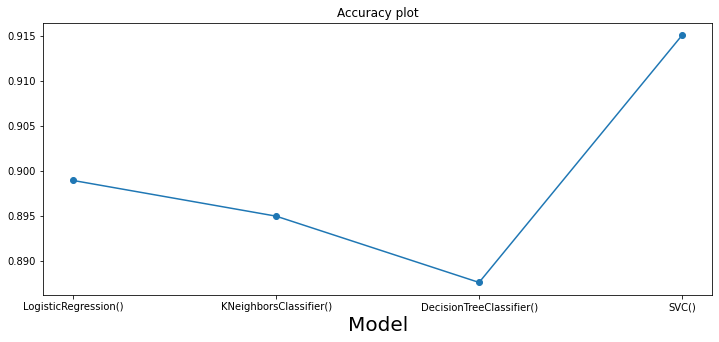

In [80]:
fig, ax = plt.subplots(figsize=(12, 5))
x=[1,2,3,4]
plt.plot(x,test_accuracy,marker="o")
plt.xlabel("Model",fontsize=20)
plt.xticks(x,model_name)
plt.title("Accuracy plot")

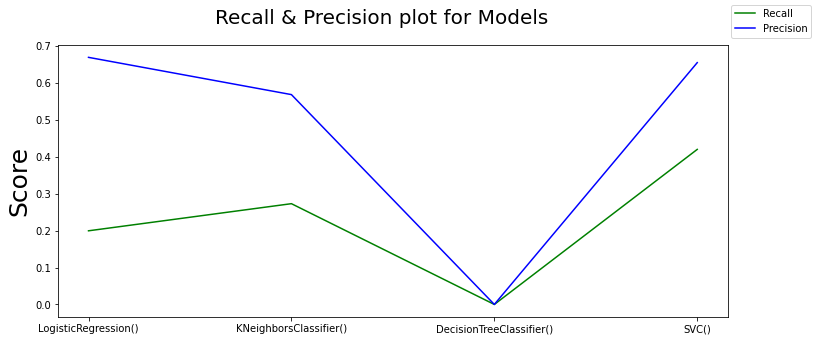

In [78]:
fig, ax = plt.subplots(figsize=(12, 5))
  
x=[1,2,3,4]  
labels = ["Recall", "Precision"]

fig.suptitle('Recall & Precision plot for Models', fontsize=20)

l1 = ax.plot(x, test_recall, color="green")
l2 = ax.plot(x, test_precision, color="blue")
plt.xticks(x,model_name)

ax.set_ylabel('Score', fontsize=25)
fig.legend([l1, l2], labels=labels,loc="upper right")
plt.subplots_adjust(right=0.9)
  
plt.show()

In [50]:
d = {'Model':model_name,'Execution Time':time_execution,'Accuracy':test_accuracy,'Recall':test_recall,'Precision':test_precision,'Best Paramater':best_param}
performance_matrix = pd.DataFrame(d)

performance_matrix

,Model,Execution Time,Accuracy,Recall,Precision,Best Paramater
0,LogisticRegression(),24.651042,0.898924,0.199424,0.669082,"{'model__C': 2.7825594022071245, 'model__penal..."
1,KNeighborsClassifier(),198.567001,0.894958,0.272858,0.568216,"{'model__leaf_size': 15, 'model__n_neighbors':..."
2,DecisionTreeClassifier(),4.425010,0.887594,0.000000,0.000000,"{'model__max_depth': 2, 'model__min_impurity_d..."
3,SVC(),26.647332,0.915049,0.419847,0.654762,"{'model__gamma': 0.1, 'model__kernel': 'linear'}"


In [81]:
best_param

[{'model__C': 2.7825594022071245, 'model__penalty': 'l2'},
 {'model__leaf_size': 15,
  'model__n_neighbors': 9,
  'model__weights': 'uniform'},
 {'model__max_depth': 2,
  'model__min_impurity_decrease': 0.01,
  'model__min_samples_split': 0.1},
 {'model__gamma': 0.1, 'model__kernel': 'linear'}]

#### To look which model is returned as best model with pipelining multiple model with hypertuning parameters with Cross validation

In [51]:
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression()],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(0, 4, 10)},
                {'classifier': [DecisionTreeClassifier()],
                 'classifier__min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
                 'classifier__max_depth': [2, 5, 10],
                 'classifier__min_samples_split': [0.1, 0.2, 0.05]},
                {'classifier': [KNeighborsClassifier()],
                 'classifier__n_neighbors': range(1, 20, 2)},
                {'classifier': [SVC()],
                 'classifier__kernel': ['rbf', 'linear'],
                 'classifier__gamma': [0.1, 1.0]}]

best_model = GridSearchCV(pipe, search_space, scoring = 'accuracy', cv=2, verbose=0).fit(X, y)

In [52]:
best_model.best_params_

{'classifier': LogisticRegression(),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2'}

In [82]:
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression()],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(0, 4, 10)},
                {'classifier': [DecisionTreeClassifier()],
                 'classifier__min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
                 'classifier__max_depth': [2, 5, 10],
                 'classifier__min_samples_split': [0.1, 0.2, 0.05]},
                {'classifier': [KNeighborsClassifier()],
                 'classifier__n_neighbors': range(1, 20, 2)},
                {'classifier': [SVC()],
                 'classifier__kernel': ['rbf', 'linear'],
                 'classifier__gamma': [0.1, 1.0]}]

best_model = GridSearchCV(pipe, search_space, scoring = 'recall', cv=2, verbose=0).fit(X, y)

In [83]:
best_model.best_params_

{'classifier': DecisionTreeClassifier(max_depth=2, min_impurity_decrease=0.01,
                        min_samples_split=0.1),
 'classifier__max_depth': 2,
 'classifier__min_impurity_decrease': 0.01,
 'classifier__min_samples_split': 0.1}

##### Questions